In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
#import pytorch for building RNN model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#import scaler for normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
#define a function to split data into train and test sets
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    data = np.array(data);
    
    #split into test and train
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN, use dropout to avoid overfitting
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function, using RELU to prevent shrinking the gradient
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="RNN", loss_func="mse"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    train_loss = []
    test_loss = []
    if (loss_func == "l1"):
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item()
    
        length = len(train_loader)
        avg_loss /= length
        train_loss.append(avg_loss)
        print("Epoch {}/{} Done, Total Training Loss: {}".format(epoch, EPOCHS, avg_loss))
        
        predictions = []
        values = []
        
        h = model.init_hidden(1)
        
        #define loss function criterion
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            #default
            criterion = nn.MSELoss()
        
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss2 = criterion(out, label.float()).item()
            avg_loss2 += loss2
            
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        test_loss.append(avg_loss2)
        print("Total Testing MSELoss: {}".format(avg_loss2))
        
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, train_loss, test_loss, predictions, values

def evaluate(model, test_loader, loss_func="mse"):
    with torch.no_grad():
        predictions = []
        values = []
        test_loss = []
        h = model.init_hidden(1)
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            loss_arr.append(loss)
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss, loss_arr

In [4]:
#data source path
dataset_folder = "../../dataset/"

# Microsoft

In [5]:
#load data
microsoft_df = pd.read_csv(dataset_folder + "microsoft.csv")

In [6]:
#use the close prices for analysis
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [7]:
#normalize the data to the range 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [8]:
#split the data
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)


In [9]:
#prepare the data to make it suitable for putting into the model
#organize data into batches to make the backpropogation easier
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [10]:
lr = 0.001
rnn_micro, micro_train_mse, micro_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="mse")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0020415131353434548
Total Testing MSELoss: 0.1535218507051468
Total Time Elapsed: 0.16851508400000004 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/20 Done, Total Training Loss: 0.044594117990011395
Total Testing MSELoss: 0.25463804602622986
Total Time Elapsed: 0.15395499099999999 seconds

Epoch 3/20 Done, Total Training Loss: 0.03855515495554239
Total Testing MSELoss: 0.38662049174308777
Total Time Elapsed: 0.154323443 seconds

Epoch 4/20 Done, Total Training Loss: 0.020077124380092043
Total Testing MSELoss: 0.26972347497940063
Total Time Elapsed: 0.1359740330000001 seconds

Epoch 5/20 Done, Total Training Loss: 0.016939042093351443
Total Testing MSELoss: 0.14591354131698608
Total Time Elapsed: 0.14419817499999965 seconds

Epoch 6/20 Done, Total Training Loss: 0.014406636328990193
Total Testing MSELoss: 0.058027658611536026
Total Time Elapsed: 0.13475060999999933 seconds

Epoch 7/20 Done, Total Training Loss: 0.007173172698753046
Total Testing MSELoss: 0.03058302402496338
Total Time Elapsed: 0.17462792899999968 seconds

Epoch 8/20 Done, Total Training Loss: 0.0011104976176677548
Total Testing MSELoss: 0.032844964414834976

In [11]:
loss_df = pd.DataFrame(micro_train_mse, columns = ["micro_train_mse"])
loss_df['micro_test_mse'] = micro_test_mse
loss_df

,micro_train_mse,micro_test_mse
0,0.002042,0.153522
1,0.044594,0.254638
2,0.038555,0.386620
3,0.020077,0.269723
4,0.016939,0.145914
5,0.014407,0.058028
6,0.007173,0.030583
7,0.001110,0.032845
8,0.001468,0.031167
9,0.000579,0.023411


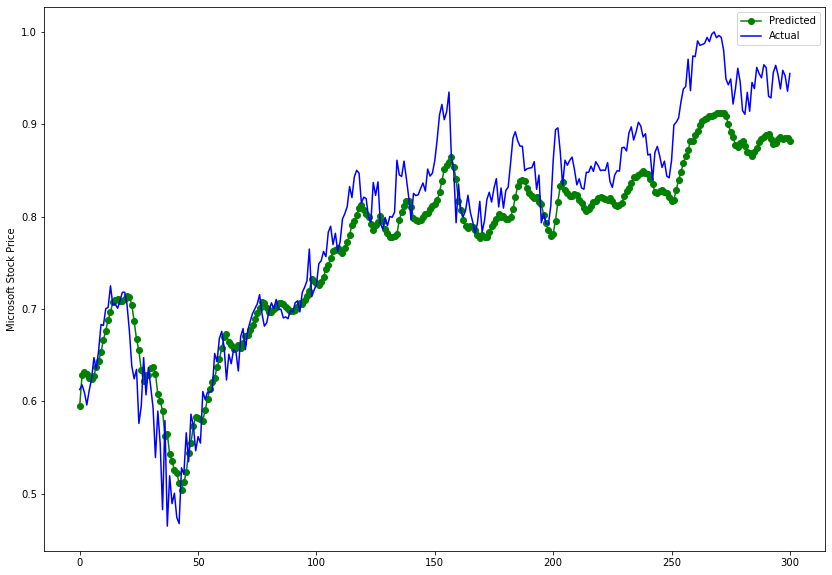

In [12]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

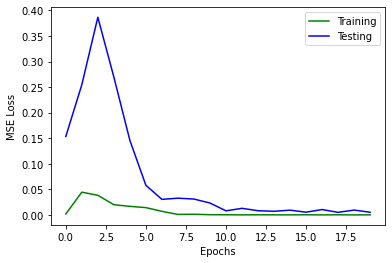

In [13]:
plt.plot(micro_train_mse, color="g", label="Training")
plt.plot(micro_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [14]:
lr = 0.001
rnn_micro2, micro_train_l1, micro_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.027726785783228035
Total Testing MSELoss: 0.428588330745697
Total Time Elapsed: 0.15308471800000056 seconds

Epoch 2/20 Done, Total Training Loss: 0.2228161825521572
Total Testing MSELoss: 0.5946903824806213
Total Time Elapsed: 0.1540227010000006 seconds

Epoch 3/20 Done, Total Training Loss: 0.15954463519281833
Total Testing MSELoss: 0.591683566570282
Total Time Elapsed: 0.1435816120000002 seconds

Epoch 4/20 Done, Total Training Loss: 0.13755747899916526
Total Testing MSELoss: 0.5115152597427368
Total Time Elapsed: 0.14787439699999894 seconds

Epoch 5/20 Done, Total Training Loss: 0.16054121236241348
Total Testing MSELoss: 0.4752023220062256
Total Time Elapsed: 0.13952659200000106 seconds

Epoch 6/20 Done, Total Training Loss: 0.14640919568419858
Total Testing MSELoss: 0.54558265209198
Total Time Elapsed: 0.15937752299999985 seconds

Epoch 7/20 Done, Total Training Loss: 0.09699442654193656
Total Testing MSELoss: 

In [15]:
loss_df['micro_train_l1'] = micro_train_l1
loss_df['micro_test_l1'] = micro_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1
0,0.002042,0.153522,0.027727,0.428588
1,0.044594,0.254638,0.222816,0.594690
2,0.038555,0.386620,0.159545,0.591684
3,0.020077,0.269723,0.137557,0.511515
4,0.016939,0.145914,0.160541,0.475202
5,0.014407,0.058028,0.146409,0.545583
6,0.007173,0.030583,0.096994,0.323878
7,0.001110,0.032845,0.124825,0.308384
8,0.001468,0.031167,0.065060,0.115466
9,0.000579,0.023411,0.043562,0.124090


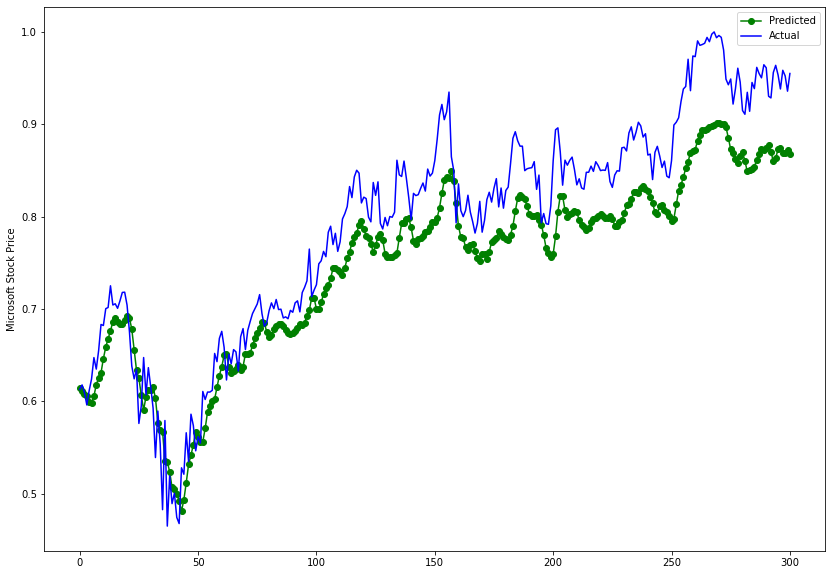

In [16]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

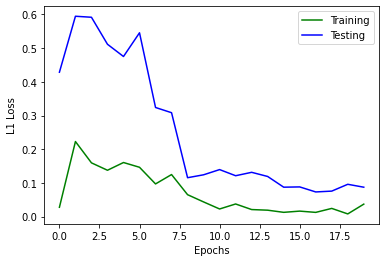

In [17]:
plt.plot(micro_train_l1, color="g", label="Training")
plt.plot(micro_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data

In [18]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [19]:
#normalize the data to the range 0-1
scaler = MinMaxScaler()
scaled_art1 = scaler.fit_transform(art_data.values.reshape(-1,1))
scaled_art1

array([[0.44861011],
       [0.44234504],
       [0.41956507],
       ...,
       [0.38776852],
       [0.4008299 ],
       [0.41748377]])

In [20]:
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art1, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [21]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [22]:
lr = 0.001
rnn_art1, art1_train_mse, art1_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.03617242600315936


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.0015804850263521075
Total Time Elapsed: 0.6147262929999986 seconds

Epoch 2/20 Done, Total Training Loss: 0.021497481663143365
Total Testing MSELoss: 0.0030934170354157686
Total Time Elapsed: 0.6365241909999995 seconds

Epoch 3/20 Done, Total Training Loss: 0.012775932923682126
Total Testing MSELoss: 0.010331965051591396
Total Time Elapsed: 0.6226004289999985 seconds

Epoch 4/20 Done, Total Training Loss: 0.006445748515294066
Total Testing MSELoss: 2.2936468667467125e-05
Total Time Elapsed: 0.6014984380000001 seconds

Epoch 5/20 Done, Total Training Loss: 0.0013310111068306838
Total Testing MSELoss: 6.261122325668111e-05
Total Time Elapsed: 0.5939878790000002 seconds

Epoch 6/20 Done, Total Training Loss: 0.0009066088439814828
Total Testing MSELoss: 0.00019287409668322653
Total Time Elapsed: 0.6204887699999997 seconds

Epoch 7/20 Done, Total Training Loss: 0.0007425950034802964
Total Testing MSELoss: 0.00032748462399467826
Total Time Elapsed: 0.6106872200000009

In [23]:
loss_df['art1_train_mse'] = art1_train_mse
loss_df['art1_test_mse'] = art1_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610


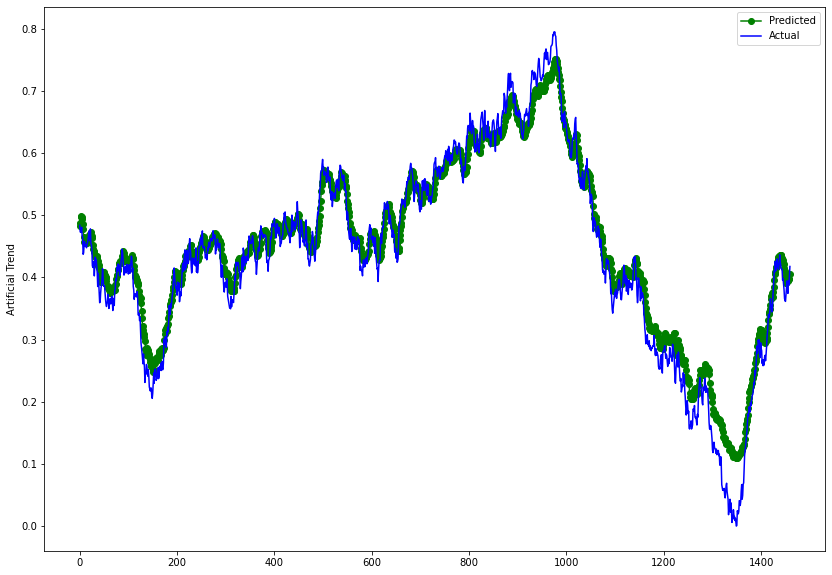

In [24]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

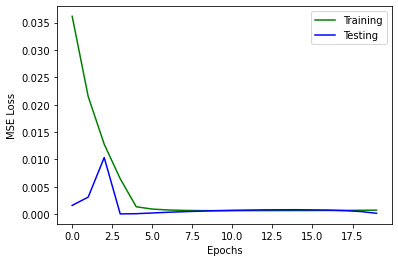

In [25]:
plt.plot(art1_train_mse, color="g", label="Training")
plt.plot(art1_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [26]:
lr = 0.001
rnn_art1_l1, art1_train_l1, art1_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.2072827389033941
Total Testing MSELoss: 0.0026641488075256348
Total Time Elapsed: 0.6929524110000003 seconds

Epoch 2/20 Done, Total Training Loss: 0.13642012207144563
Total Testing MSELoss: 0.08480408787727356
Total Time Elapsed: 0.6447106779999991 seconds

Epoch 3/20 Done, Total Training Loss: 0.128367853013205
Total Testing MSELoss: 0.021893352270126343
Total Time Elapsed: 0.6142296570000028 seconds

Epoch 4/20 Done, Total Training Loss: 0.09486871166666458
Total Testing MSELoss: 0.09939947724342346
Total Time Elapsed: 0.6168430409999992 seconds

Epoch 5/20 Done, Total Training Loss: 0.07870331494608424
Total Testing MSELoss: 0.03600701689720154
Total Time Elapsed: 0.6217055879999975 seconds

Epoch 6/20 Done, Total Training Loss: 0.05776157506465257
Total Testing MSELoss: 0.008799076080322266
Total Time Elapsed: 0.6228140729999971 seconds

Epoch 7/20 Done, Total Training Loss: 0.03658277787022538
Total Testing MS

In [27]:
loss_df['art1_train_l1'] = art1_train_l1
loss_df['art1_test_l1'] = art1_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398


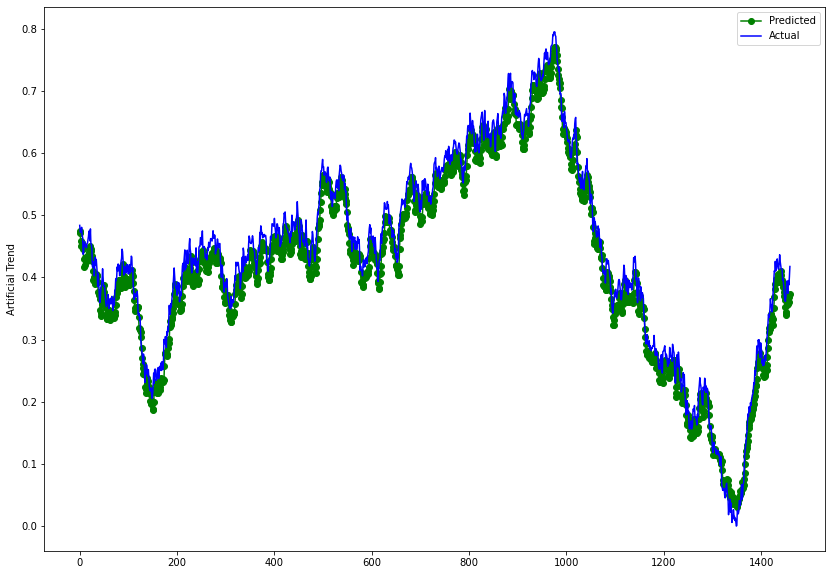

In [28]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

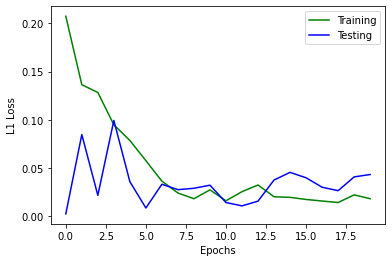

In [29]:
plt.plot(art1_train_l1, color="g", label="Training")
plt.plot(art1_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Crude Oil

In [30]:
oil_data = pd.read_csv(dataset_folder +"oil.csv")
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])
oil_data.set_index('DATE',inplace=True)
len(oil_data)

1566

In [31]:
oil_data[oil_data['DCOILBRENTEU'] == "."] = np.NaN
oil_data.dropna(inplace=True)
oil_data['DCOILBRENTEU'] = oil_data['DCOILBRENTEU'].astype("float")
oil_data

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.40


In [32]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_oil = scaler.fit_transform(oil_data.values)

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)


In [33]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [34]:
lr = 0.001
rnn_oil, oil_train_mse, oil_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.02755782331836312
Total Testing MSELoss: 0.25128865242004395
Total Time Elapsed: 0.15639639799999827 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/20 Done, Total Training Loss: 0.029842518616198122
Total Testing MSELoss: 0.21624210476875305
Total Time Elapsed: 0.1593771220000022 seconds

Epoch 3/20 Done, Total Training Loss: 0.03795973132486994
Total Testing MSELoss: 0.14874590933322906
Total Time Elapsed: 0.1523108620000002 seconds

Epoch 4/20 Done, Total Training Loss: 0.03983961319777576
Total Testing MSELoss: 0.13093458116054535
Total Time Elapsed: 0.14428297000000612 seconds

Epoch 5/20 Done, Total Training Loss: 0.030035377823208507
Total Testing MSELoss: 0.178227499127388
Total Time Elapsed: 0.15005586699999895 seconds

Epoch 6/20 Done, Total Training Loss: 0.037512458946653886
Total Testing MSELoss: 0.01997910626232624
Total Time Elapsed: 0.14583395600000415 seconds

Epoch 7/20 Done, Total Training Loss: 0.045161127145739124
Total Testing MSELoss: 0.05671953782439232
Total Time Elapsed: 0.17240346300000198 seconds

Epoch 8/20 Done, Total Training Loss: 0.045733504680500026
Total Testing MSELoss: 0.0461123362183570

In [35]:
loss_df['oil_train_mse'] = oil_train_mse
loss_df['oil_test_mse'] = oil_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058


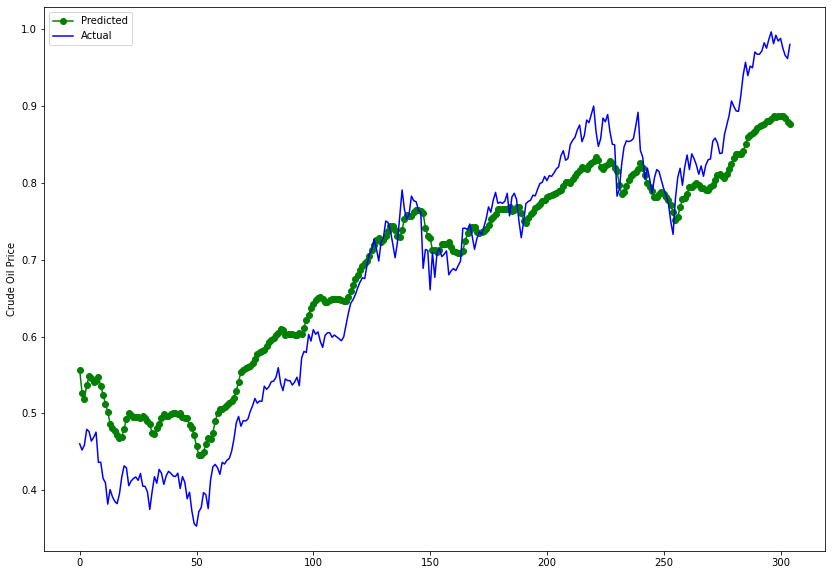

In [36]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

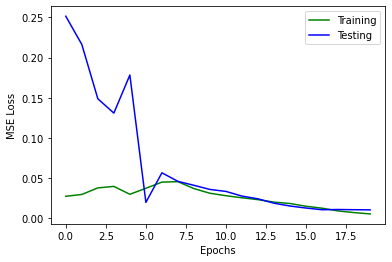

In [37]:
plt.plot(oil_train_mse, color="g", label="Training")
plt.plot(oil_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [38]:
lr = 0.001
rnn_oil2, oil_train_l1, oil_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.18873140166856742
Total Testing MSELoss: 0.3950105309486389
Total Time Elapsed: 0.15953844300000242 seconds

Epoch 2/20 Done, Total Training Loss: 0.11247076393154107
Total Testing MSELoss: 0.48835015296936035
Total Time Elapsed: 0.15427576399999765 seconds

Epoch 3/20 Done, Total Training Loss: 0.17540111716248488
Total Testing MSELoss: 0.3487294912338257
Total Time Elapsed: 0.15033620000000525 seconds

Epoch 4/20 Done, Total Training Loss: 0.15198873316771105
Total Testing MSELoss: 0.4804581105709076
Total Time Elapsed: 0.14561344399999854 seconds

Epoch 5/20 Done, Total Training Loss: 0.1854829394111508
Total Testing MSELoss: 0.3721432089805603
Total Time Elapsed: 0.15484929499999822 seconds

Epoch 6/20 Done, Total Training Loss: 0.15957193929505975
Total Testing MSELoss: 0.31847280263900757
Total Time Elapsed: 0.14251332199999922 seconds

Epoch 7/20 Done, Total Training Loss: 0.14078345105640197
Total Testing MS

In [39]:
loss_df['oil_train_l1'] = oil_train_l1
loss_df['oil_test_l1'] = oil_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289,0.188731,0.395011
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242,0.112471,0.488350
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746,0.175401,0.348729
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935,0.151989,0.480458
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227,0.185483,0.372143
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979,0.159572,0.318473
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720,0.140783,0.305607
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112,0.147519,0.313972
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189,0.146622,0.261132
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058,0.164352,0.220051


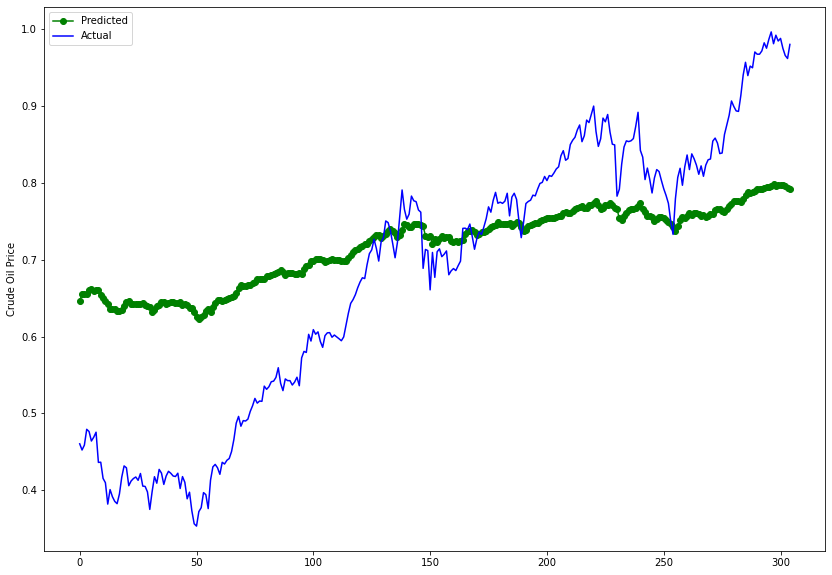

In [40]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

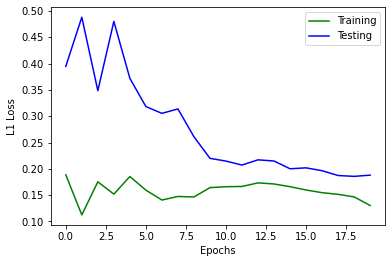

In [41]:
plt.plot(oil_train_l1, color="g", label="Training")
plt.plot(oil_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Bitcoin

In [42]:
coin_df = pd.read_csv(dataset_folder + "coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date', inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [43]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_coin = scaler.fit_transform(coin_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)


In [44]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [45]:
lr = 0.001
rnn_coin, coin_train_mse, coin_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.004850354587688344


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.16500632464885712
Total Time Elapsed: 0.3338136969999965 seconds

Epoch 2/20 Done, Total Training Loss: 0.005435796930632441
Total Testing MSELoss: 0.1896146982908249
Total Time Elapsed: 0.25832934199999613 seconds

Epoch 3/20 Done, Total Training Loss: 0.0052816898984585
Total Testing MSELoss: 0.1787620633840561
Total Time Elapsed: 0.27119435700000594 seconds

Epoch 4/20 Done, Total Training Loss: 0.005744631446501352
Total Testing MSELoss: 0.1789115071296692
Total Time Elapsed: 0.2905160680000023 seconds

Epoch 5/20 Done, Total Training Loss: 0.005614423370327524
Total Testing MSELoss: 0.2005564570426941
Total Time Elapsed: 0.3033632029999964 seconds

Epoch 6/20 Done, Total Training Loss: 0.0037156322332275275
Total Testing MSELoss: 0.1619756668806076
Total Time Elapsed: 0.27163658399999946 seconds

Epoch 7/20 Done, Total Training Loss: 0.0053119461518887166
Total Testing MSELoss: 0.1799529641866684
Total Time Elapsed: 0.28576847400000105 seconds

Epoch 8/20 

In [46]:
loss_df['coin_train_mse'] = coin_train_mse
loss_df['coin_test_mse'] = coin_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289,0.188731,0.395011,0.004850,0.165006
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242,0.112471,0.488350,0.005436,0.189615
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746,0.175401,0.348729,0.005282,0.178762
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935,0.151989,0.480458,0.005745,0.178912
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227,0.185483,0.372143,0.005614,0.200556
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979,0.159572,0.318473,0.003716,0.161976
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720,0.140783,0.305607,0.005312,0.179953
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112,0.147519,0.313972,0.003975,0.176075
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189,0.146622,0.261132,0.003437,0.159188
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058,0.164352,0.220051,0.003348,0.144983


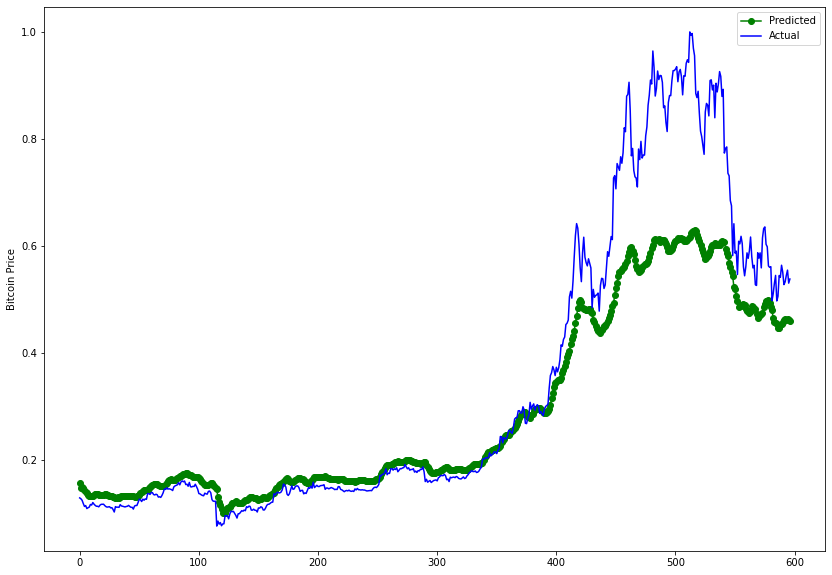

In [47]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

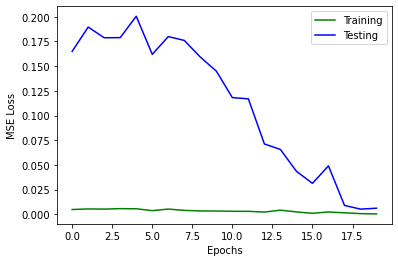

In [48]:
plt.plot(coin_train_mse, color="g", label="Training")
plt.plot(coin_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [49]:
lr = 0.001
rnn_coin2, coin_train_l1, coin_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.037489457052779965
Total Testing MSELoss: 0.37306517362594604
Total Time Elapsed: 0.27772303400000453 seconds

Epoch 2/20 Done, Total Training Loss: 0.0481455678220939
Total Testing MSELoss: 0.390931099653244
Total Time Elapsed: 0.26135868000000073 seconds

Epoch 3/20 Done, Total Training Loss: 0.04166062149168873
Total Testing MSELoss: 0.3740195035934448
Total Time Elapsed: 0.25716280599999664 seconds

Epoch 4/20 Done, Total Training Loss: 0.04282473394571728
Total Testing MSELoss: 0.3660789728164673
Total Time Elapsed: 0.27445097399999696 seconds

Epoch 5/20 Done, Total Training Loss: 0.06365929745339058
Total Testing MSELoss: 0.3956896662712097
Total Time Elapsed: 0.2631624670000008 seconds

Epoch 6/20 Done, Total Training Loss: 0.050069193782070906
Total Testing MSELoss: 0.3643081784248352
Total Time Elapsed: 0.25691738399999764 seconds

Epoch 7/20 Done, Total Training Loss: 0.05096998285955271
Total Testing MSE

In [50]:
loss_df['coin_train_l1'] = coin_train_l1
loss_df['coin_test_l1'] = coin_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289,0.188731,0.395011,0.004850,0.165006,0.037489,0.373065
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242,0.112471,0.488350,0.005436,0.189615,0.048146,0.390931
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746,0.175401,0.348729,0.005282,0.178762,0.041661,0.374020
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935,0.151989,0.480458,0.005745,0.178912,0.042825,0.366079
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227,0.185483,0.372143,0.005614,0.200556,0.063659,0.395690
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979,0.159572,0.318473,0.003716,0.161976,0.050069,0.364308
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720,0.140783,0.305607,0.005312,0.179953,0.050970,0.322821
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112,0.147519,0.313972,0.003975,0.176075,0.049410,0.364071
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189,0.146622,0.261132,0.003437,0.159188,0.059363,0.351145
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058,0.164352,0.220051,0.003348,0.144983,0.060060,0.393729


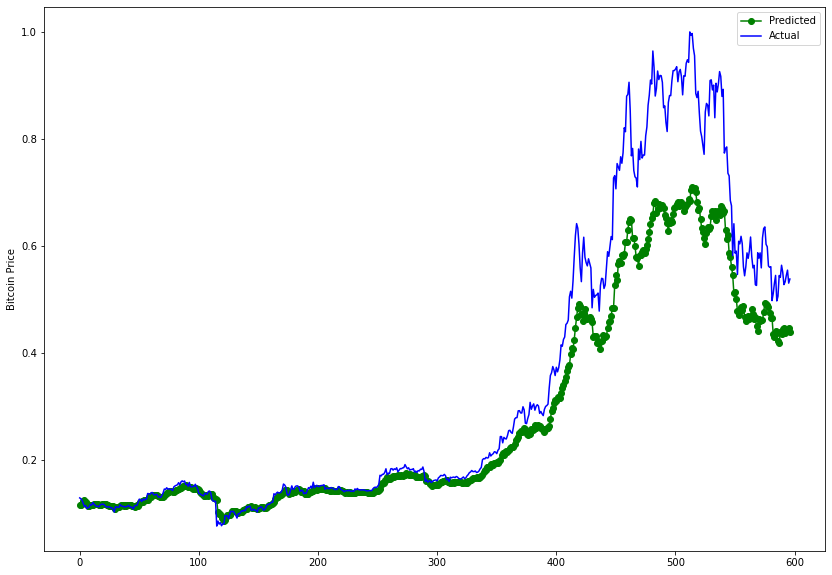

In [51]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

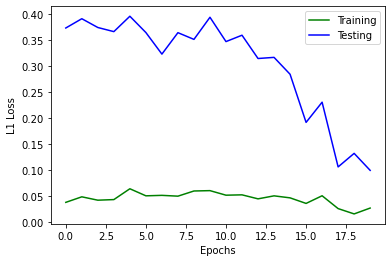

In [52]:
plt.plot(coin_train_l1, color="g", label="Training")
plt.plot(coin_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## S&P500

In [53]:
sp_df = pd.read_csv(dataset_folder + "sp500.csv")
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df = pd.DataFrame(sp_df['SP500'])
sp_df.dropna(inplace=True)
sp_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [54]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_sp = scaler.fit_transform(sp_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [55]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [56]:
lr = 0.001
rnn_sp, sp_train_mse, sp_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.00046272722096480317
Total Testing MSELoss: 0.7330592274665833
Total Time Elapsed: 0.16953169800000012 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/20 Done, Total Training Loss: 0.0005062629685568254
Total Testing MSELoss: 0.6988093256950378
Total Time Elapsed: 0.19367003600000032 seconds

Epoch 3/20 Done, Total Training Loss: 0.0005185784754818779
Total Testing MSELoss: 0.7004276514053345
Total Time Elapsed: 0.18202665700000153 seconds

Epoch 4/20 Done, Total Training Loss: 0.0005571203361863685
Total Testing MSELoss: 0.7038248777389526
Total Time Elapsed: 0.1634666739999986 seconds

Epoch 5/20 Done, Total Training Loss: 0.0005329851491017672
Total Testing MSELoss: 0.7378515601158142
Total Time Elapsed: 0.17515175700000185 seconds

Epoch 6/20 Done, Total Training Loss: 0.0005262328574027399
Total Testing MSELoss: 0.7056048512458801
Total Time Elapsed: 0.18641114700000116 seconds

Epoch 7/20 Done, Total Training Loss: 0.0004279370287497192
Total Testing MSELoss: 0.6947860717773438
Total Time Elapsed: 0.17147654200000062 seconds

Epoch 8/20 Done, Total Training Loss: 0.0004719119671605654
Total Testing MSELoss: 0.7025519013

In [57]:
loss_df['sp_train_mse'] = sp_train_mse
loss_df['sp_test_mse'] = sp_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289,0.188731,0.395011,0.004850,0.165006,0.037489,0.373065,0.000463,0.733059
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242,0.112471,0.488350,0.005436,0.189615,0.048146,0.390931,0.000506,0.698809
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746,0.175401,0.348729,0.005282,0.178762,0.041661,0.374020,0.000519,0.700428
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935,0.151989,0.480458,0.005745,0.178912,0.042825,0.366079,0.000557,0.703825
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227,0.185483,0.372143,0.005614,0.200556,0.063659,0.395690,0.000533,0.737852
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979,0.159572,0.318473,0.003716,0.161976,0.050069,0.364308,0.000526,0.705605
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720,0.140783,0.305607,0.005312,0.179953,0.050970,0.322821,0.000428,0.694786
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112,0.147519,0.313972,0.003975,0.176075,0.049410,0.364071,0.000472,0.702552
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189,0.146622,0.261132,0.003437,0.159188,0.059363,0.351145,0.000387,0.707210
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058,0.164352,0.220051,0.003348,0.144983,0.060060,0.393729,0.000432,0.693206


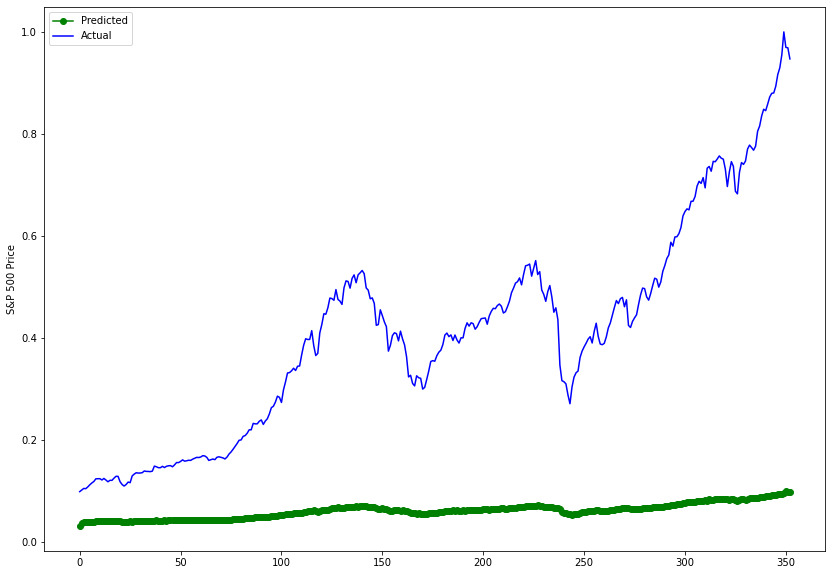

In [58]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

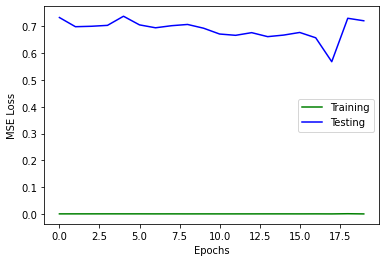

In [59]:
plt.plot(sp_train_mse, color="g", label="Training")
plt.plot(sp_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [60]:
lr = 0.001
rnn_sp2, sp_train_l1, sp_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.010443163817399181
Total Testing MSELoss: 0.9022378921508789
Total Time Elapsed: 0.17681283299999961 seconds

Epoch 2/20 Done, Total Training Loss: 0.01274068093566298
Total Testing MSELoss: 0.9137230515480042
Total Time Elapsed: 0.18161933100000027 seconds

Epoch 3/20 Done, Total Training Loss: 0.0123212208987256
Total Testing MSELoss: 0.9005842208862305
Total Time Elapsed: 0.18737906099999435 seconds

Epoch 4/20 Done, Total Training Loss: 0.012686492090737871
Total Testing MSELoss: 0.9098638296127319
Total Time Elapsed: 0.16419826500000312 seconds

Epoch 5/20 Done, Total Training Loss: 0.011434392258789476
Total Testing MSELoss: 0.8815823793411255
Total Time Elapsed: 0.1751813909999953 seconds

Epoch 6/20 Done, Total Training Loss: 0.01873041050434536
Total Testing MSELoss: 0.8349480628967285
Total Time Elapsed: 0.19152475900000354 seconds

Epoch 7/20 Done, Total Training Loss: 0.01939939233654348
Total Testing MS

In [61]:
loss_df['sp_train_l1'] = sp_train_l1
loss_df['sp_test_l1'] = sp_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse,sp_train_l1,sp_test_l1
0,0.002042,0.153522,0.027727,0.428588,0.036172,0.001580,0.207283,0.002664,0.027558,0.251289,0.188731,0.395011,0.004850,0.165006,0.037489,0.373065,0.000463,0.733059,0.010443,0.902238
1,0.044594,0.254638,0.222816,0.594690,0.021497,0.003093,0.136420,0.084804,0.029843,0.216242,0.112471,0.488350,0.005436,0.189615,0.048146,0.390931,0.000506,0.698809,0.012741,0.913723
2,0.038555,0.386620,0.159545,0.591684,0.012776,0.010332,0.128368,0.021893,0.037960,0.148746,0.175401,0.348729,0.005282,0.178762,0.041661,0.374020,0.000519,0.700428,0.012321,0.900584
3,0.020077,0.269723,0.137557,0.511515,0.006446,0.000023,0.094869,0.099399,0.039840,0.130935,0.151989,0.480458,0.005745,0.178912,0.042825,0.366079,0.000557,0.703825,0.012686,0.909864
4,0.016939,0.145914,0.160541,0.475202,0.001331,0.000063,0.078703,0.036007,0.030035,0.178227,0.185483,0.372143,0.005614,0.200556,0.063659,0.395690,0.000533,0.737852,0.011434,0.881582
5,0.014407,0.058028,0.146409,0.545583,0.000907,0.000193,0.057762,0.008799,0.037512,0.019979,0.159572,0.318473,0.003716,0.161976,0.050069,0.364308,0.000526,0.705605,0.018730,0.834948
6,0.007173,0.030583,0.096994,0.323878,0.000743,0.000327,0.036583,0.033383,0.045161,0.056720,0.140783,0.305607,0.005312,0.179953,0.050970,0.322821,0.000428,0.694786,0.019399,0.846238
7,0.001110,0.032845,0.124825,0.308384,0.000664,0.000432,0.024307,0.027773,0.045734,0.046112,0.147519,0.313972,0.003975,0.176075,0.049410,0.364071,0.000472,0.702552,0.017470,0.859410
8,0.001468,0.031167,0.065060,0.115466,0.000630,0.000524,0.018398,0.029216,0.037082,0.041189,0.146622,0.261132,0.003437,0.159188,0.059363,0.351145,0.000387,0.707210,0.019518,0.833055
9,0.000579,0.023411,0.043562,0.124090,0.000617,0.000610,0.027515,0.032398,0.031306,0.036058,0.164352,0.220051,0.003348,0.144983,0.060060,0.393729,0.000432,0.693206,0.018779,0.826314


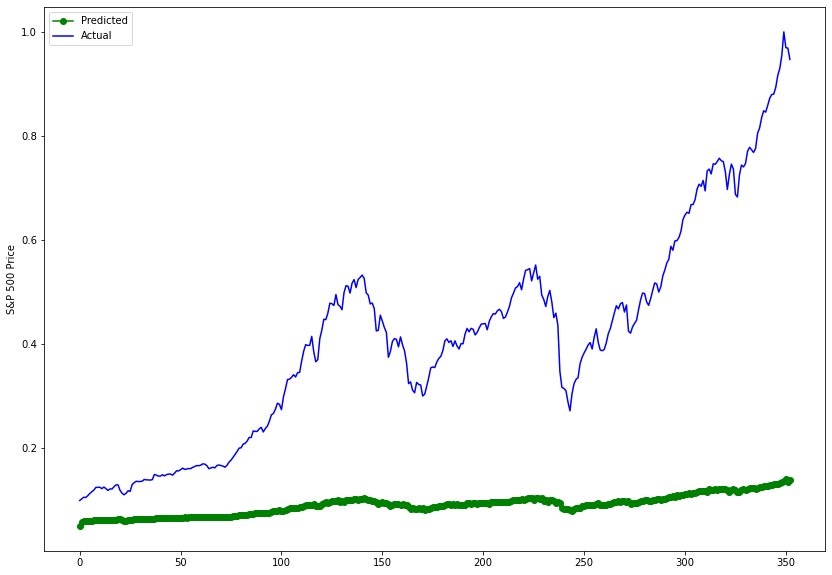

In [62]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

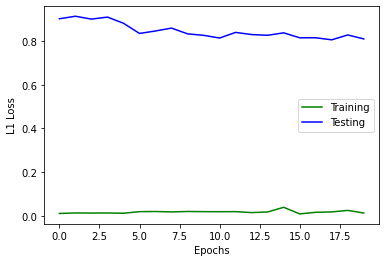

In [63]:
plt.plot(sp_train_l1, color="g", label="Training")
plt.plot(sp_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## 